<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/notebooks/07__one_Conv2Dlayer_AE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learned Image Compression (LIC) using [(Compressive) Autoencoders](https://www.lherranz.org/2022/08/24/neural-image-compression-in-a-nutshell-part-1-main-idea/) using 1 hidden layer and no quantization of the latent space

       input                           output
    +---------+                      +---------+
    | 28x28x1 |                      | 28x28x1 |
    +---------+                      +---------+
         | flatten()                      ^ reshape(28, 28, 1)
         v                                |
     +-------+ dense() +----+ dense() +-------+
     | 28*28 |-------->| 32 |-------->| 28*28 |
     +-------+         +----+         +-------+
                     code layer
    <----------------------->
           encoder             decoder
                       <---------------------->

Notice that we have found a lossy compact representation of 28x28 scalars (integers) using only 32 (floats) scalars.

In [1]:
# A simple autoencoder with only one hidden layer.

import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import Sequence
from skimage.io import imread
from sklearn.model_selection import train_test_split
from skimage.transform import resize

print(tf.__version__)

2.15.0


In [2]:
# This variable controls the number of hidden neurons. Notice that the output of a neuron is a floating point number.
LATENT_SPACE_LENGTH = 10

img_width, img_height = 28, 28
img_length = img_height * img_width

DATASET = 'mnist'  # See https://www.tensorflow.org/datasets/catalog/
DATA_URL = f'https://storage.googleapis.com/tensorflow/tf-keras-datasets/{DATASET}.npz'
# DATASET = 'fashion_mnist'
# DATA_URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"
path = tf.keras.utils.get_file(f'{DATASET}.npz', DATA_URL)
#with np.load(path) as data:
#    x_train = data['x_train']
#    y_train = data['x_train']
#    x_test = data['x_test']
#    y_test = data['x_test']
with np.load(path) as data:
#    x_train = data['x_train']
#    x_test = data['x_test']
#    y_train = x_train
#    y_test = x_test
    x_train = data['x_train']
    y_train = data['x_train']
    x_test = data['x_test']
    y_test = data['y_test']

# Pipelines.
train_DS = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_DS = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define how to use the datasets, preprocess, etc.

def process_x(image, label):
    # The input images are reshaped (to have only one dimension) and normalized to [0, 1].
    #processed_img = tf.reshape(image, (img_height * img_width, 1))
    processed_img = tf.reshape(image, (img_height, img_width, 1))
    processed_img = tf.cast(processed_img, tf.float32) / 255.
    #processed_img = tf.cast(image, tf.float32) / 255.
    # The input dataset has been labeled, but labels are ignored in the rest of the pipeline.
    return processed_img, label

def process_y(image, label):
    # The output images are already in 1D. Notice that in autoencoder, the objective is to generate the same output than the input.
    return image, image

# During each training iteration, the model will process batches of 64 examples, and the training data will be shuffled with a buffer size of 100.
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_DS = train_DS.map(process_x)
train_DS = train_DS.map(process_y)
train_DS = train_DS.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_DS = test_DS.map(process_x)
test_DS = test_DS.map(process_y)
test_DS = test_DS.batch(BATCH_SIZE)

In [3]:
input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
enc_conv_1 = tf.keras.layers.Conv2D(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(input_layer)
enc_conv_2 = tf.keras.layers.Conv2D(50, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(enc_conv_1)
flatten = tf.keras.layers.Flatten()(enc_conv_2)
enc_fc_1 = tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu")(flatten)

encoded = tf.keras.layers.Dense(LATENT_SPACE_LENGTH, use_bias=True, activation="relu")(enc_fc_1)

dec_fc_2 = tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu")(encoded)
dec_fc_1 = tf.keras.layers.Dense(2450, use_bias=True, activation="leaky_relu")(dec_fc_2)
reshape = tf.keras.layers.Reshape((7, 7, 50))(dec_fc_1)
dec_conv_2 = tf.keras.layers.Conv2DTranspose(50, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(reshape)
#dec_conv_1 = tf.keras.layers.Conv2DTranspose(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(dec_conv_2)
dec_conv_1 = tf.keras.layers.Conv2DTranspose(1, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu")(dec_conv_2)

In [4]:
autoencoder = tf.keras.Model(inputs=input_layer, outputs=dec_conv_1)

In [5]:
# To see the "latents" (content of the hidden layer) while we train the network, we define a new "model" with only the encoder.
encoder = tf.keras.Model(input_layer, encoded)

In [6]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 20)        520       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 50)          25050     
                                                                 
 flatten (Flatten)           (None, 2450)              0         
                                                                 
 dense (Dense)               (None, 500)               1225500   
                                                                 
 dense_1 (Dense)             (None, 10)                5010      
                                                                 
 dense_2 (Dense)             (None, 500)               5500  

157/157 [==============================] - 1s 3ms/step


<Figure size 640x480 with 0 Axes>

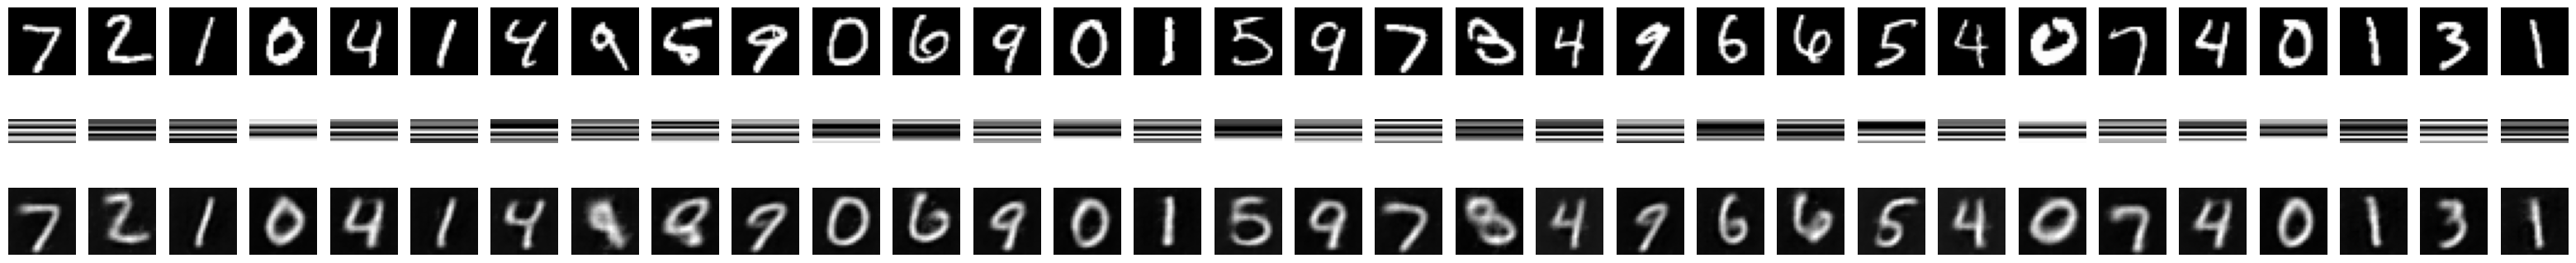

157/157 [==============================] - 1s 3ms/step


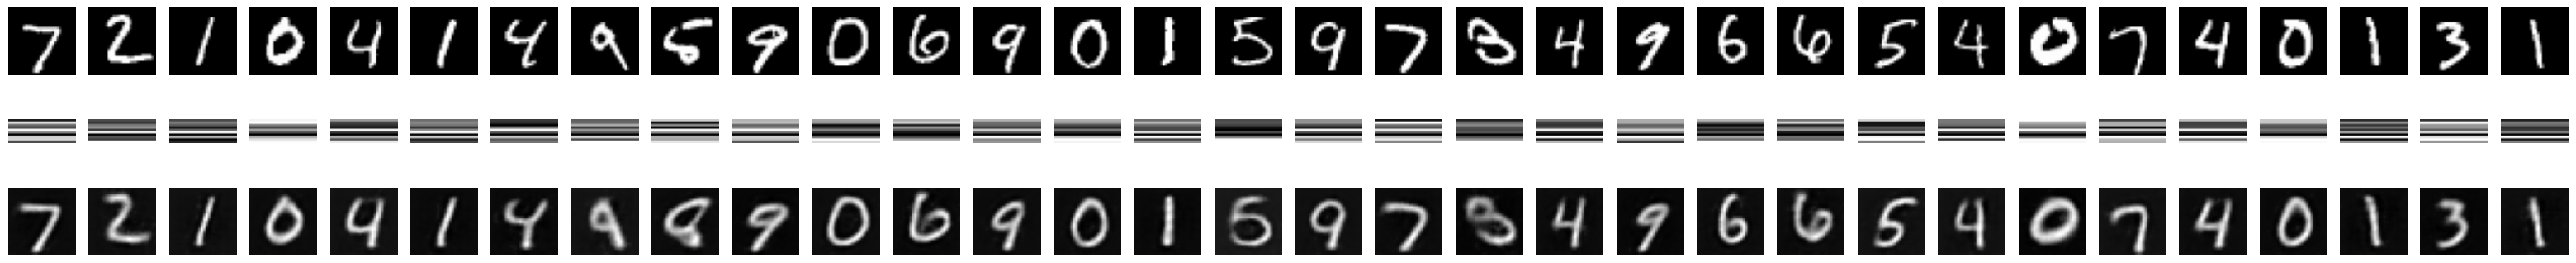

157/157 [==============================] - 1s 3ms/step


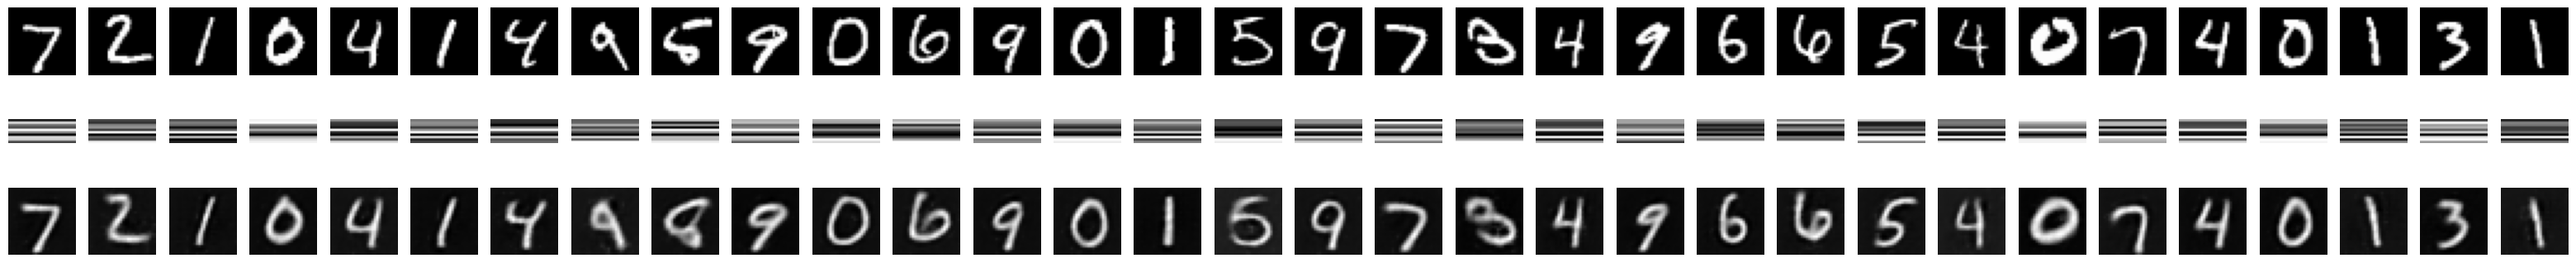

In [7]:
# Let's train.

# Number of times that the complete dataset is used to train the autoencoder. In this case, because we want to show the progressive reconstruction of some images, we train the encoder using only one epoch.
EPOCHS = 1

# Number of times that the autoencoder is trained. Notice that if we don't want to see how the model is learning between epochs, it is not necessary to iterate the fit() method, because we can increase the number of epochs.
ITERATIONS = 3
plt.gray()
for i in range(ITERATIONS):
    autoencoder.fit(train_DS, epochs=EPOCHS, validation_data=test_DS)

    # Show the learning.
    plt.figure(figsize=(40, 4))

    n = len(train_DS)
    if n > 32:
        n = 32

    # Show the originals (using the pipeline).
    for images in test_DS.take(1):
        for i in range(n):
            ax = plt.subplot(3, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                plt.axis("off")
            except:
                pass

    # See the latent space (as images).
    latent_imgs = encoder.predict(test_DS)
    #print("type latent", type(latent_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(resize(latent_imgs[i], (LATENT_SPACE_LENGTH, img_width)))
        plt.axis("off")

    # See the reconstructions.
    reconstructed_imgs = autoencoder.predict(test_DS)
    #print(type(reconstructed_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.axis("off")

    plt.show()